In [86]:
import sys
from data_helper import *

import keras
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
#from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from numpy import array
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # to make any matplotlib plot automatically a 20x10


import configparser
config = configparser.ConfigParser()
config.read('config/mylstmconfig.ini')

scaler = MinMaxScaler(feature_range=(0,1))
eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')

#callbacks_list = [EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=2)]
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
look_back = int(config['model']['look_back'])

In [87]:
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

In [88]:
train_percent = float(config['model']['train_percent'])
validation_percent = 1.0 - train_percent
n_jobs = int(config['model']['n_jobs'])
epochs = int(config['model']['epochs'])
neurons = int(config['model']['neurons'])
look_back = int(config['model']['look_back'])

In [89]:
point_list = [point_name, 'aiTIT4045','Future_TMY','Outside_Air_Temp_Forecast']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)
df['aiTIT4045'].fillna(df['Outside_Air_Temp_Forecast'], inplace = True)
df['aiTIT4045'].fillna(df['Future_TMY'], inplace = True)
df.loc[(df['aiTIT4045'].pct_change() == 0.0 ), 'aiTIT4045'] = np.nan
df['aiTIT4045'].fillna(df['Outside_Air_Temp_Forecast'], inplace = True)
df['aiTIT4045'].fillna(df['Future_TMY'], inplace = True)
df.drop(['Outside_Air_Temp_Forecast','Future_TMY'], axis = 1, inplace = True)
start = df.shape[0]
df = df.dropna(how='any')
print(f"Removed: {start - df.shape[0]} rows")

Grabbing WebIDs ...
WebID collection complete!
14:52:58: Sending API request... Chunk 1 of 1
14:53:04: Response recieved for 4 tags! (6.14)


/Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1027: FutureWarning: The errors argument is deprecated and will be removed in a future release. Use nonexistent='NaT' or nonexistent='raise' instead.
  "instead.", FutureWarning)


Removed: 24 rows


In [90]:
df.head()

,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2016-01-01 00:00:00,2550.633333,40.409643
2016-01-01 01:00:00,2535.975618,40.079128
2016-01-01 02:00:00,2538.258333,40.090998
2016-01-01 03:00:00,2548.635795,40.114107
2016-01-01 04:00:00,2556.464644,39.902123


In [91]:
df, df1 = clean_train_data(df, eval_expression=["df.loc[df['GBSF_Electricity_Demand_kBtu'] > 2400]","df.loc[df.index.year >= 2019]"])
#print(df.shape)
#print(df1.shape)

Evaluating: df.loc[df['GBSF_Electricity_Demand_kBtu'] > 2400]
Evaluating: df.loc[df.index.year >= 2019]


In [92]:
df1.shape

(5071, 2)

In [93]:
df = create_standard_multivariable_df(df)
df1 = create_standard_multivariable_df(df1)

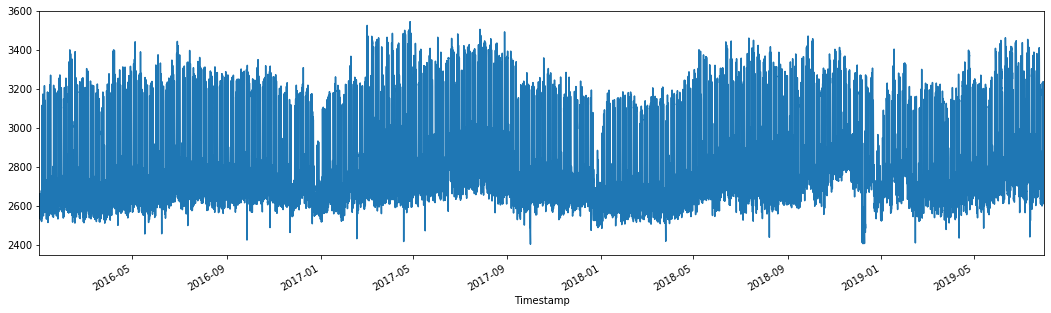

In [94]:
df[point_name].plot(figsize = (18,5))

```def add_rolling_mean(df, point_loc, rolling):
    return df.iloc[ : , point_loc].rolling(rolling).mean()```

```kwargs = {'point_loc': 0, 'rolling': '12h'}
df = add_variable_to_df(df, add_rolling_mean, col_name="Rolling12_mean", kwargs = kwargs)
df1 = add_variable_to_df(df1, add_rolling_mean, col_name="Rolling12_mean", kwargs = kwargs)```

In [95]:
print(f"df: {df.shape}")
print(f"df1: {df1.shape}")

df: (31293, 48)
df1: (5070, 48)


In [96]:
np.setdiff1d(df.columns,df1.columns)


array([], dtype=object)

In [97]:
def scale_keras(X, y):
    # normalize the dataset
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler((0, 1))
    X = scaler_x.fit_transform(X)
    y = scaler_y.fit_transform(np.array(y).reshape((-1,1)))
    # split into train and test sets
    train_size = int(len(X) * 0.7)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[test_size:len(X)]
    y_train, y_test = y[0:train_size], y[test_size:len(y)]
    return X_train, X_test, y_train, y_test, scaler_x, scaler_y

In [98]:
y = df[point_name]
X = df.drop(columns=point_name)
y1 = df1[point_name]
X1 = df1.drop(columns=point_name)

In [99]:
X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_keras(X, y)
X1_train, X1_test, y1_train, y1_test, scaler_x1, scaler_y1 = scale_keras(X1, y1)

In [100]:
X_train.shape

(21905, 47)

In [101]:
y_train.shape

(21905, 1)

In [102]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X1_train = np.reshape(X1_train, (X1_train.shape[0], 1, X1_train.shape[1]))
X1_test = np.reshape(X1_test, (X1_test.shape[0], 1, X1_test.shape[1]))

In [103]:
X_train.shape

(21905, 1, 47)

In [104]:
train = DataFrame()
val = DataFrame()
np.random.seed(42)

for i in range(n_jobs):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
    model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(optimizer = Adam(lr = 0.001), loss = 'mean_squared_error')
    #X,y = get_train()
    #valX, valY = get_val()
    # fit model
    history = model.fit(X_train, y_train, epochs = epochs, validation_split = 0.3, shuffle = False)
    # story history
    train[str(i)] = history.history['loss']
    val[str(i)] = history.history['val_loss']

Train on 15333 samples, validate on 6572 samples
Epoch 1/90
15333/15333 [==============================] - 5s 350us/step - loss: 0.0092 - val_loss: 0.0031
Epoch 2/90
15333/15333 [==============================] - 3s 216us/step - loss: 0.0019 - val_loss: 0.0027
Epoch 3/90
15333/15333 [==============================] - 3s 211us/step - loss: 0.0016 - val_loss: 0.0027
Epoch 4/90
15333/15333 [==============================] - 3s 218us/step - loss: 0.0014 - val_loss: 0.0028
Epoch 5/90
15333/15333 [==============================] - 3s 219us/step - loss: 0.0013 - val_loss: 0.0029
Epoch 6/90
15333/15333 [==============================] - 3s 216us/step - loss: 0.0012 - val_loss: 0.0031
Epoch 7/90
15333/15333 [==============================] - 3s 204us/step - loss: 0.0012 - val_loss: 0.0032
Epoch 8/90
15333/15333 [==============================] - 3s 201us/step - loss: 0.0012 - val_loss: 0.0031
Epoch 9/90
15333/15333 [==============================] - 3s 205us/step - loss: 0.0011 - val_loss: 0.00

15333/15333 [==============================] - 2s 146us/step - loss: 9.2521e-04 - val_loss: 0.0014
Epoch 77/90
15333/15333 [==============================] - 2s 139us/step - loss: 9.1522e-04 - val_loss: 0.0014
Epoch 78/90
15333/15333 [==============================] - 2s 138us/step - loss: 9.0679e-04 - val_loss: 0.0014
Epoch 79/90
15333/15333 [==============================] - 2s 137us/step - loss: 8.9947e-04 - val_loss: 0.0014
Epoch 80/90
15333/15333 [==============================] - 2s 138us/step - loss: 8.9251e-04 - val_loss: 0.0014
Epoch 81/90
15333/15333 [==============================] - 2s 138us/step - loss: 8.8486e-04 - val_loss: 0.0014
Epoch 82/90
15333/15333 [==============================] - 2s 137us/step - loss: 8.7752e-04 - val_loss: 0.0014
Epoch 83/90
15333/15333 [==============================] - 2s 140us/step - loss: 8.6962e-04 - val_loss: 0.0014
Epoch 84/90
15333/15333 [==============================] - 2s 141us/step - loss: 8.6248e-04 - val_loss: 0.0014
Epoch 85/90
1

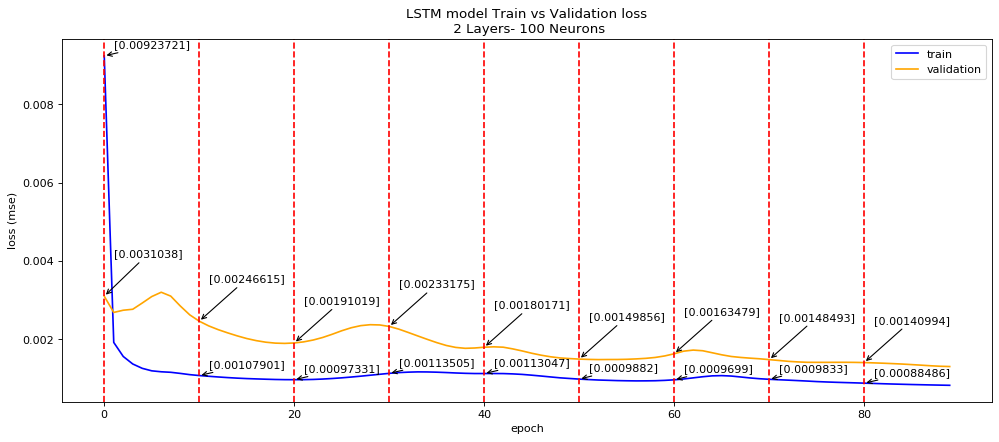

In [105]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
show_every = 10

vertical_lines = [x for x in range(epochs) if x % show_every == 0]

plt.plot(train, color='blue', label='train')
plt.plot(val, color='orange', label='validation')
plt.title(f'LSTM model Train vs Validation loss\n 2 Layers- {neurons} Neurons')
plt.ylabel('loss (mse)')
plt.xlabel('epoch')
plt.legend()

unflat = train.values.tolist()
unflat1 = val.values.tolist()
flatten = [ item for sublist in  unflat for item in sublist]
flatten1 = [ item for sublist in  unflat1 for item in sublist]
import peakutils
from peakutils.plot import plot as pplot

#indexes = peakutils.indexes(flatten, thres=0.005, min_dist=1)
#indexes1 = peakutils.indexes(flatten1, thres=0.2, min_dist=1)

#pplot(train.index, train.values, indexes)
#pplot(val.index, val.values, indexes1)
for xc in vertical_lines:
    plt.axvline(x=xc, color = 'r', linestyle = '--')
for i,j in zip(train.index, train.values):
    if i % show_every == 0:
        plt.annotate(str(j), xy = (i,j ), xytext=(i+1, j+.000200),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
for i,j in zip(val.index, val.values):
    if i % show_every == 0:
        plt.annotate(str(j), xy = (i,j ), xytext=(i+1, j+.0010),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
#plt.savefig('new_300_epochs.png')

plt.show()

In [ ]:
#weight_name = config['outfiles']['weight_name']
#arch_name = config['outfiles']['arch_name']
# serialize model to JSON
#model_json = history.model.to_json()
#with open(arch_name, "w") as json_file:
#    json_file.write('noOATChange')
# serialize weights to HDF5
#history.model.save_weights(weight_name)
#print("Saved model to disk")

R2 of train = 0.968
R2 of test = -0.154

RMSE of train = 41.861
RMSE of test = 135.131

MAE of train = -15.638
MAE of test = -126.408


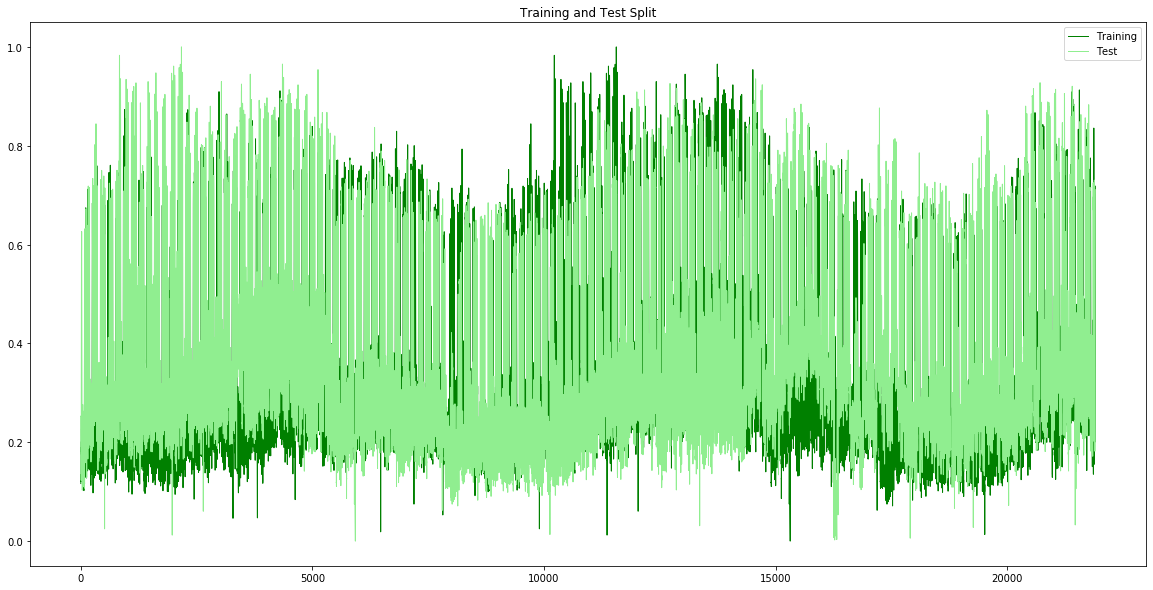

<Figure size 1296x144 with 0 Axes>

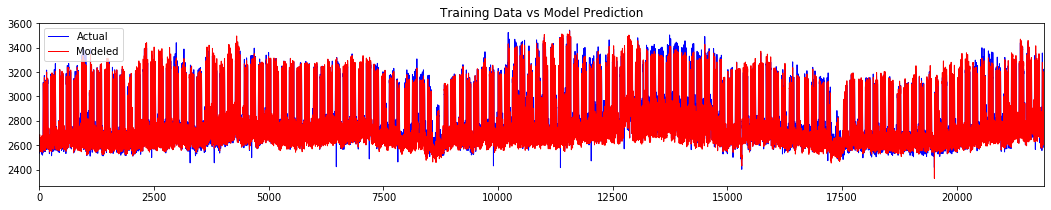

<Figure size 1296x144 with 0 Axes>

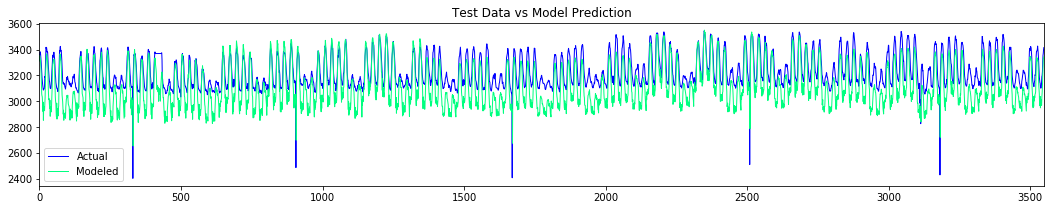

In [106]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
plt.plot(y_train, linewidth=1, color='green')
plt.plot(y_test, color='lightgreen', linewidth=1)
plt.title("Training and Test Split")
plt.legend(['Training','Test'])

pred_train = history.model.predict(X_train)
pred_train_inv = scaler_y.inverse_transform(pred_train.reshape(-1,1))
pred_test = history.model.predict(X1_test)
pred_test_inv = scaler_y.inverse_transform(pred_test.reshape(-1,1))
pred_test_inv = pred_test_inv#+200
plt.figure(figsize=(18,2))
training_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y_train).reshape((-1,)),
                                   "Modeled":pred_train_inv.reshape((-1,))}, index=range(len(y_train)))
training_comparison.sort_index().plot(figsize=(18,3),
                         title="Training Data vs Model Prediction",
                         linewidth=1,
                         color=['blue','red'])
 
plt.figure(figsize=(18,2))
test_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y1_test).reshape((-1,)),
                                   "Modeled":pred_test_inv.reshape((-1,))}, index=range(len(y1_test)))
test_comparison.sort_index().plot(figsize=(18,3),
                     title="Test Data vs Model Prediction",
                     linewidth=1,
                     colormap='winter')

r2_train = r2_score(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1))
print(f"R2 of train = {round(r2_train,3)}")
r2_test = r2_score(scaler_y.inverse_transform(y1_test).reshape((-1,)), pred_test_inv.reshape(-1,1))
print(f"R2 of test = {round(r2_test,3)}")
print()
rmse_train = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1)))
print(f"RMSE of train = {round(rmse_train,3)}")
rmse_test = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y1_test).reshape((-1,)), pred_test_inv.reshape(-1,1)))
print(f"RMSE of test = {round(rmse_test,3)}")
print()
mae_train = np.median((pred_train_inv.reshape(-1,1) - scaler_y.inverse_transform(y_train).reshape((-1,))))
print(f"MAE of train = {round(mae_train,3)}")
mae_test = np.median((pred_test_inv.reshape(-1,1) - scaler_y.inverse_transform(y1_test).reshape((-1,))))
print(f"MAE of test = {round(mae_test,3)}")

In [107]:
row = (test_comparison['Actual'] - test_comparison['Modeled']).abs().idxmax()
#test_comparison

In [108]:
test_comparison.loc[row,:].to_frame().T

,Actual,Modeled
2509,2509.85793,3105.688232


In [109]:
test_comparison.eval('Difference = (Actual - Modeled)/ Actual * 100', inplace=True)
#test_comparison['Difference'] = test_comparison['Actual'] - test_comparison['Modeled']
test_comparison.head()

,Actual,Modeled,Difference
0,3357.124426,3310.726074,1.382086
1,3366.373282,3350.708008,0.465346
2,3382.699277,3314.717529,2.009689
3,3381.155261,3323.719482,1.698703
4,3364.913508,3300.568604,1.912231


In [110]:
test_comparison['Difference']  = test_comparison['Difference'].abs()

In [111]:
test_comparison.sort_values(by = 'Difference', ascending= False).head(7)

,Actual,Modeled,Difference
3181,2430.103880,3017.528564,24.172822
2509,2509.857930,3105.688232,23.739603
330,2403.183549,2967.404297,23.478055
1670,2407.829494,2928.067871,21.606114
906,2486.590322,2924.052246,17.592843
331,3187.046545,2653.886475,16.728970
3182,3178.709056,2720.728027,14.407768


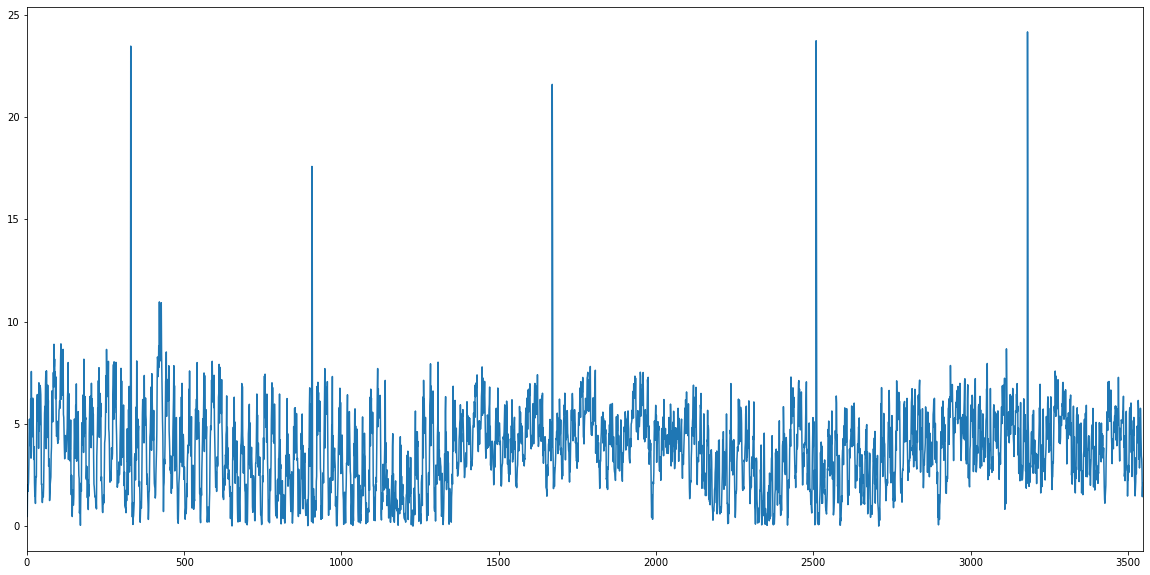

In [112]:
test_comparison['Difference'].plot(figsize = (20,10))

In [113]:
test_comparison.loc[test_comparison['Difference'] <300].mean()

Actual        3231.191660
Modeled       3115.203596
Difference       3.759432
dtype: float64